In [1]:
import sys
import os

# 경로 세팅 (src 폴더 추가)
SRC_DIR = os.path.abspath("src")
sys.path.append(SRC_DIR)

# 장치 확인
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 장치:", device)

사용 장치: cuda


In [2]:
DATA_DIR = "/home/kang/PythonProject/Project_1/SAR/Data/v_2"
PRETRAIN_DIR = "./checkpoints/pretrain"
SEGMENT_DIR = "./checkpoints/segmentation"

# 체크포인트 폴더
os.makedirs(PRETRAIN_DIR, exist_ok=True)
os.makedirs(SEGMENT_DIR, exist_ok=True)

In [3]:
# Pretraining (Optical)

from src.dataset_loader import SentinelPairDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [6]:
# Optical Dataset 준비
class Sentinel2Dataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transform=None):
        self.dataset = SentinelPairDataset(base_dir, transform)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        _, optical_img, label = self.dataset[idx]
        return optical_img, label

# 데이터 증강 설정 (주의: Albumentations 최신버전 기준으로 height, width 명시!)
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224)),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={"image2": "image"})

train_dataset = Sentinel2Dataset(DATA_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 정의 (ImageNet pretrained)
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Pretraining loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Pretrain Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), os.path.join(PRETRAIN_DIR, f"resnet18_epoch{epoch+1}.pth"))

Pretrain Epoch [1/10] Loss: 0.0858
Pretrain Epoch [2/10] Loss: 0.0362
Pretrain Epoch [3/10] Loss: 0.0298
Pretrain Epoch [4/10] Loss: 0.0282
Pretrain Epoch [5/10] Loss: 0.0216
Pretrain Epoch [6/10] Loss: 0.0172
Pretrain Epoch [7/10] Loss: 0.0189
Pretrain Epoch [8/10] Loss: 0.0170
Pretrain Epoch [9/10] Loss: 0.0188
Pretrain Epoch [10/10] Loss: 0.0153


In [4]:
from models.segmentation_model import SegmentationModel
import time

In [5]:
class SARSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transform=None):
        self.dataset = SentinelPairDataset(base_dir, transform)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sar_img, optical_img, label = self.dataset[idx]
        combined_img = torch.cat([sar_img, optical_img], dim=0)  # [6, H, W]
        return combined_img, label

# Segmentation용 transform (dual transform 필요)
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224)),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={"image2": "image"})

seg_dataset = SARSegmentationDataset(DATA_DIR, transform=train_transform)
seg_loader = DataLoader(seg_dataset, batch_size=8, shuffle=True)

# pretrained weight 로딩
pretrained_path = os.path.join(PRETRAIN_DIR, "resnet18_epoch10.pth")
model = SegmentationModel(n_classes=4, pretrained_backbone_path=pretrained_path)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fine-tuning loop 시작
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    start_time = time.time()

    for imgs, labels in seg_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        # 현재 label이 scene label 이므로 global pooling 적용 (임시)
        outputs = outputs.mean(dim=[2, 3])
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    end_time = time.time()
    epoch_time = end_time - start_time
    avg_loss = total_loss / len(seg_loader)

    print(f"Seg Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | Time: {epoch_time:.2f} sec")

    torch.save(model.state_dict(), os.path.join(SEGMENT_DIR, f"seg_epoch{epoch+1}.pth"))

Loaded pretrained backbone weights from: ./checkpoints/pretrain/resnet18_epoch10.pth
Seg Epoch [1/20] Loss: 0.3489 | Time: 112.29 sec
Seg Epoch [2/20] Loss: 0.1747 | Time: 112.01 sec
Seg Epoch [3/20] Loss: 0.1237 | Time: 112.50 sec
Seg Epoch [4/20] Loss: 0.1114 | Time: 113.49 sec
Seg Epoch [5/20] Loss: 0.0868 | Time: 113.51 sec
Seg Epoch [6/20] Loss: 0.0767 | Time: 112.50 sec
Seg Epoch [7/20] Loss: 0.0680 | Time: 112.28 sec
Seg Epoch [8/20] Loss: 0.0640 | Time: 113.98 sec
Seg Epoch [9/20] Loss: 0.0606 | Time: 113.40 sec
Seg Epoch [10/20] Loss: 0.0550 | Time: 114.19 sec
Seg Epoch [11/20] Loss: 0.0520 | Time: 114.02 sec
Seg Epoch [12/20] Loss: 0.0488 | Time: 112.41 sec
Seg Epoch [13/20] Loss: 0.0498 | Time: 114.14 sec
Seg Epoch [14/20] Loss: 0.0428 | Time: 113.65 sec
Seg Epoch [15/20] Loss: 0.0397 | Time: 113.14 sec
Seg Epoch [16/20] Loss: 0.0409 | Time: 113.07 sec
Seg Epoch [17/20] Loss: 0.0335 | Time: 113.16 sec
Seg Epoch [18/20] Loss: 0.0351 | Time: 111.06 sec
Seg Epoch [19/20] Loss: 

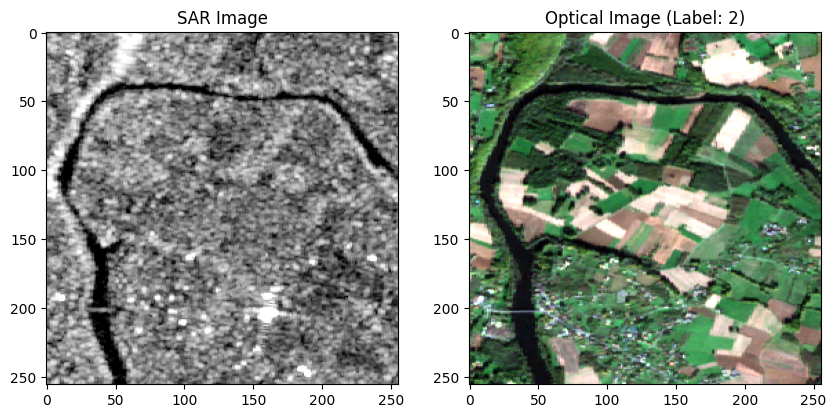

In [12]:
import matplotlib.pyplot as plt
import cv2
import random
def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    sar_img, optical_img, label = dataset[idx]

    sar_img_vis = sar_img[..., 0]
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("SAR Image")
    plt.imshow(sar_img_vis, cmap='gray')

    plt.subplot(1,2,2)
    plt.title(f"Optical Image (Label: {label})")
    plt.imshow(optical_img)
    plt.show()

# 실행
visualize_random_sample(dataset)


In [13]:
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    start_time = time.time()

    for imgs, labels in seg_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        outputs = outputs.mean(dim=[2, 3])
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    end_time = time.time()
    epoch_time = end_time - start_time
    avg_loss = total_loss / len(seg_loader)
    
    # Loss 기록
    loss_history.append(avg_loss)

    print(f"Seg Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | Time: {epoch_time:.2f} sec")


Seg Epoch [1/20] Loss: 0.0302 | Time: 105.57 sec
Seg Epoch [2/20] Loss: 0.0277 | Time: 105.52 sec
Seg Epoch [3/20] Loss: 0.0308 | Time: 106.02 sec
Seg Epoch [4/20] Loss: 0.0324 | Time: 106.82 sec
Seg Epoch [5/20] Loss: 0.0283 | Time: 106.45 sec
Seg Epoch [6/20] Loss: 0.0229 | Time: 105.03 sec
Seg Epoch [7/20] Loss: 0.0279 | Time: 103.77 sec
Seg Epoch [8/20] Loss: 0.0254 | Time: 104.65 sec
Seg Epoch [9/20] Loss: 0.0273 | Time: 103.59 sec
Seg Epoch [10/20] Loss: 0.0208 | Time: 103.33 sec
Seg Epoch [11/20] Loss: 0.0263 | Time: 101.76 sec
Seg Epoch [12/20] Loss: 0.0207 | Time: 100.18 sec
Seg Epoch [13/20] Loss: 0.0243 | Time: 100.14 sec
Seg Epoch [14/20] Loss: 0.0222 | Time: 103.26 sec
Seg Epoch [15/20] Loss: 0.0205 | Time: 103.34 sec
Seg Epoch [16/20] Loss: 0.0223 | Time: 102.74 sec
Seg Epoch [17/20] Loss: 0.0228 | Time: 103.85 sec
Seg Epoch [18/20] Loss: 0.0181 | Time: 103.71 sec
Seg Epoch [19/20] Loss: 0.0192 | Time: 103.50 sec
Seg Epoch [20/20] Loss: 0.0213 | Time: 103.01 sec


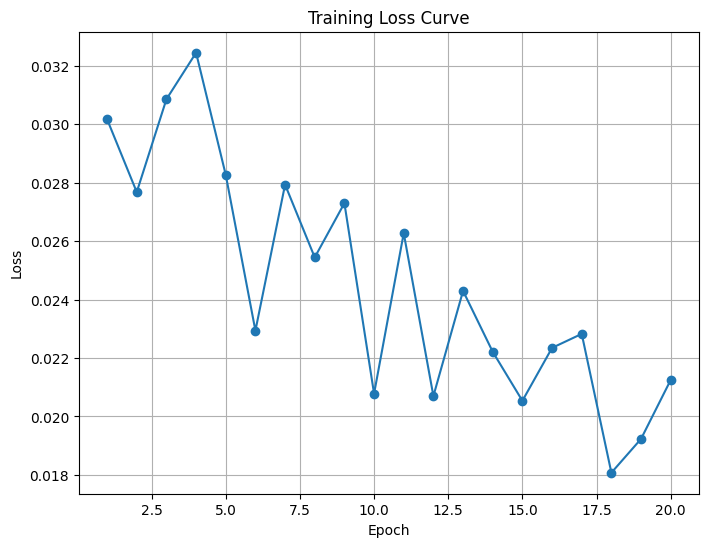

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in seg_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        outputs = outputs.mean(dim=[2,3])
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix & Accuracy
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc*100:.2f}%")
print("Confusion Matrix:")
print(cm)


Accuracy: 99.78%
Confusion Matrix:
[[3985   12    2    1]
 [   2 3997    1    0]
 [   3    1 3996    0]
 [   4    5    5 3986]]


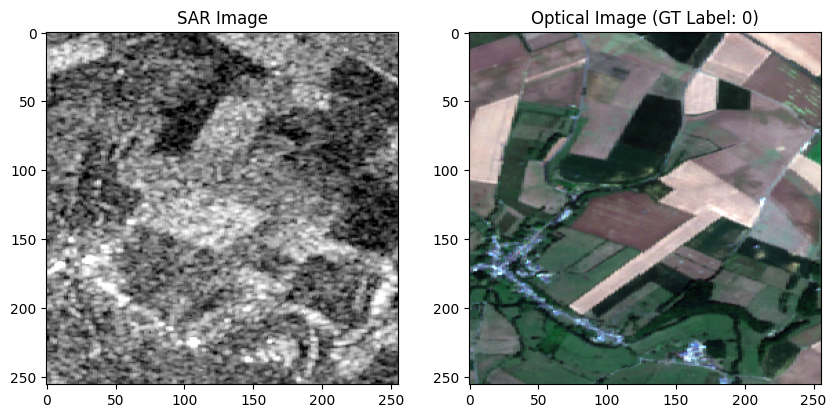

In [ ]:
eval_dataset = SentinelPairDataset(DATA_DIR, transform=None)

# 랜덤 샘플 선택
idx = random.randint(0, len(eval_dataset)-1)
sar_img, optical_img, label = eval_dataset[idx]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("SAR Image")
plt.imshow(sar_img[...,0], cmap='gray')

plt.subplot(1,2,2)
plt.title(f"Optical Image (GT Label: {label})")
plt.imshow(optical_img)

plt.show()


In [18]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SARDetTestDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.file_list = sorted(os.listdir(base_dir))
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        img_path = os.path.join(self.base_dir, file_name)

        sar_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        sar_img = np.stack([sar_img]*3, axis=-1)  # 3채널 확장

        if self.transform:
            sar_img = self.transform(image=sar_img)['image']

        return sar_img, file_name


In [19]:
test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [20]:
test_dir = "/home/kang/PythonProject/Project_1/SAR/Data/test"
test_dataset = SARDetTestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
for sar_imgs, file_names in test_loader:
    # SAR: [B, 3, H, W]
    dummy_optical = torch.zeros_like(sar_imgs)
    combined = torch.cat([sar_imgs, dummy_optical], dim=1).to(device)

    outputs = model(combined)
    outputs = outputs.mean(dim=[2, 3])
    preds = torch.argmax(outputs, dim=1)



In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

model.eval()
all_preds = []

with torch.no_grad():
    for sar_imgs, file_names in test_loader:
        dummy_optical = torch.zeros_like(sar_imgs)
        combined = torch.cat([sar_imgs, dummy_optical], dim=1).to(device)

        outputs = model(combined)
        outputs = outputs.mean(dim=[2, 3])
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())

# 지금은 label이 없는 상태라서 → 예측 분포 확인 가능
pred_counts = np.bincount(all_preds)
for cls_idx, count in enumerate(pred_counts):
    print(f"Class {cls_idx}: {count} samples predicted")


Class 0: 2093 samples predicted
Class 1: 8606 samples predicted
Class 2: 0 samples predicted
Class 3: 914 samples predicted
